In [3]:
#Librerias
import pandas as pd
import os
import kagglehub
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestRegressor

##  ***1- Importamos el Dataset***

In [4]:
#Obtengo las variables de entorno para conectarme a Kaggle
os.environ['KAGGLE_USERNAME'] = 'dcastro88'
os.environ['KAGGLE_KEY'] = '95e973135228bcb7f521606e2c6e767a'

In [5]:
path = kagglehub.dataset_download("ranadeep/credit-risk-dataset")
print("Ruta local del dataset:", path)

100%|██████████| 101M/101M [00:01<00:00, 53.6MB/s] 

Extracting files...


Ruta local del dataset: C:\Users\BRAYAN\.cache\kagglehub\datasets\ranadeep\credit-risk-dataset\versions\3


In [6]:
filename = "loan/loan.csv"
data = pd.read_csv(os.path.join(path, filename), low_memory=False)
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## ***2- Inspección Inicial***

In [7]:
data.shape

(887379, 74)

887379 registros y 74 variables

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           887379 non-null  int64  
 1   member_id                    887379 non-null  int64  
 2   loan_amnt                    887379 non-null  float64
 3   funded_amnt                  887379 non-null  float64
 4   funded_amnt_inv              887379 non-null  float64
 5   term                         887379 non-null  object 
 6   int_rate                     887379 non-null  float64
 7   installment                  887379 non-null  float64
 8   grade                        887379 non-null  object 
 9   sub_grade                    887379 non-null  object 
 10  emp_title                    835917 non-null  object 
 11  emp_length                   842554 non-null  object 
 12  home_ownership               887379 non-null  object 
 13 

In [9]:
#Primera limpieza de faltantes
null_percent = data.isnull().mean() * 100
print(null_percent)

id                   0.000000
member_id            0.000000
loan_amnt            0.000000
funded_amnt          0.000000
funded_amnt_inv      0.000000
                      ...    
all_util            97.591559
total_rev_hi_lim     7.919502
inq_fi              97.591559
total_cu_tl         97.591559
inq_last_12m        97.591559
Length: 74, dtype: float64


In [10]:
cols_to_drop = null_percent[null_percent > 10].index
print(f"Columnas a eliminar: {len(cols_to_drop)}")
print(cols_to_drop)

Columnas a eliminar: 22
Index(['desc', 'mths_since_last_delinq', 'mths_since_last_record',
       'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint',
       'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m',
       'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il',
       'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'inq_fi', 'total_cu_tl', 'inq_last_12m'],
      dtype='object')


In [11]:
data_cleaned = data.drop(columns=cols_to_drop)

In [12]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 52 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          887379 non-null  int64  
 1   member_id                   887379 non-null  int64  
 2   loan_amnt                   887379 non-null  float64
 3   funded_amnt                 887379 non-null  float64
 4   funded_amnt_inv             887379 non-null  float64
 5   term                        887379 non-null  object 
 6   int_rate                    887379 non-null  float64
 7   installment                 887379 non-null  float64
 8   grade                       887379 non-null  object 
 9   sub_grade                   887379 non-null  object 
 10  emp_title                   835917 non-null  object 
 11  emp_length                  842554 non-null  object 
 12  home_ownership              887379 non-null  object 
 13  annual_inc    

## ***3- Conversión variable loan status de categórica a binaria***

In [13]:
data_cleaned['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off', 'Issued'],
      dtype=object)

In [14]:
replace_dict = {
    'Fully Paid': 0,
    'Does not meet the credit policy. Status:Fully Paid': 0,
    'Charged Off': 1,
    'Default': 1,
    'Does not meet the credit policy. Status:Charged Off': 1,
    'Late (31-120 days)': 1,
    'Late (16-30 days)': np.nan,
    'Current': np.nan,
    'Issued': np.nan,
    'In Grace Period': np.nan
}

data_cleaned['loan_status_bin'] = data_cleaned['loan_status'].replace(replace_dict)

In [15]:
print("Valores 0 y 1:")
print(data_cleaned['loan_status_bin'].value_counts())

print("\nCantidad de NaN:")
print(data_cleaned['loan_status_bin'].isna().sum())

Valores 0 y 1:
loan_status_bin
0.0    209711
1.0     58819
Name: count, dtype: int64

Cantidad de NaN:
618849


Se descartan los registros que sean nan en la categoria loan status ya que no se tiene certeza sobre su clasificación. 

In [16]:
data_cleaned = data_cleaned[~data_cleaned['loan_status_bin'].isna()]
data_cleaned.shape

(268530, 53)

In [17]:
data_cleaned.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'loan_status_bin'],
      dtype='object')

In [18]:
data_cleaned.head(100).to_clipboard()

In [19]:
len(set(data_cleaned['member_id']))

268530

## ***4 - Limpieza de variables que no aportan valor al objetivo del proyecto***

In [20]:
#Variables que no nos aportan valor
data_cleaned = data_cleaned.drop(columns=['id', 'member_id','url','zip_code','emp_title','loan_status'])

Hay varias variables en el conjunto de datos que deben ser descartadas para la construcción del scoring crediticio, ya que contienen información que solo está disponible después de que el préstamo ha sido emitido y comienza a ser pagado.

out_prncp: Representa el saldo principal restante del préstamo. Esta información refleja cuánto dinero aún debe el prestatario en un momento dado, por lo que solo se conoce después de la aprobación del préstamo.

out_prncp_inv: Es el saldo principal restante específicamente del dinero aportado por los inversores. Al igual que la anterior, es una variable que solo se actualiza una vez se ha desembolsado el préstamo y se han hecho pagos.

total_pymnt: Muestra la suma total de todos los pagos realizados por el prestatario hasta la fecha. Refleja el comportamiento histórico de pago del cliente, lo cual no se conoce al momento de la evaluación inicial.

total_pymnt_inv: Indica el total pagado a los inversores hasta el momento. También depende del comportamiento del cliente tras el desembolso.

total_rec_prncp: Corresponde al total del capital que ya ha sido devuelto por el prestatario. Solo se conoce con el paso del tiempo y no puede usarse para predecir el riesgo antes de otorgar el préstamo.

total_rec_int: Muestra la suma de intereses ya pagados por el cliente. Es otra variable que depende del historial posterior al otorgamiento.

total_rec_late_fee: Indica el total de intereses por pagos atrasados que se han recaudado. Su existencia presupone que el préstamo ya ha sido otorgado y que han ocurrido retrasos.

recoveries: Refleja la cantidad de dinero recuperado después de una posible mora o incumplimiento. Es una variable completamente posterior al evento crediticio.

collection_recovery_fee: Es la suma pagada por el proceso de recuperación de deuda. Su valor también depende de si hubo incumplimientos luego del préstamo.

last_pymnt_d: Fecha del último pago registrado. Claramente, solo puede conocerse una vez el cliente ha empezado a pagar.

last_pymnt_amnt: Monto del último pago realizado. Al igual que la fecha, es posterior a la decisión crediticia.

last_credit_pull_d: Fecha en la que se obtuvo la información crediticia más reciente. Aunque podría parecer útil, suele estar desactualizada respecto al momento de la solicitud inicial, y no siempre está disponible.

In [21]:
data_cleaned.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'pymnt_plan', 'purpose',
       'title', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'loan_status_bin'],
      dtype='object')

In [22]:
data_cleaned = data_cleaned.drop(columns=[
    'out_prncp',
    'out_prncp_inv',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_prncp',
    'total_rec_int',
    'total_rec_late_fee',
    'recoveries',
    'collection_recovery_fee',
    'last_pymnt_d',
    'last_pymnt_amnt',
    'last_credit_pull_d',
    'title',
    'policy_code',
    'pymnt_plan',
    'funded_amnt', 
    'funded_amnt_inv',
    'issue_d',
    'pymnt_plan',
    'grade', 
    'sub_grade', 
    'verification_status',
    'initial_list_status',
    'int_rate', 
    'installment',
    'term'
])

In [23]:
data_cleaned.columns

Index(['loan_amnt', 'emp_length', 'home_ownership', 'annual_inc', 'purpose',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'collections_12_mths_ex_med', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'loan_status_bin'],
      dtype='object')

In [24]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 268530 entries, 0 to 887371
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   268530 non-null  float64
 1   emp_length                  257809 non-null  object 
 2   home_ownership              268530 non-null  object 
 3   annual_inc                  268526 non-null  float64
 4   purpose                     268530 non-null  object 
 5   addr_state                  268530 non-null  object 
 6   dti                         268530 non-null  float64
 7   delinq_2yrs                 268501 non-null  float64
 8   earliest_cr_line            268501 non-null  object 
 9   inq_last_6mths              268501 non-null  float64
 10  open_acc                    268501 non-null  float64
 11  pub_rec                     268501 non-null  float64
 12  revol_bal                   268530 non-null  float64
 13  revol_util         

## ***5. Limpieza e imputación de valores faltantes***

De las variables elegidas hasta este momento se evalua el porcentaje de datos faltantes

In [25]:
missing_percent = data_cleaned.isnull().mean() * 100
missing_percent.sort_values(ascending=False)

total_rev_hi_lim              24.800209
tot_cur_bal                   24.800209
tot_coll_amt                  24.800209
emp_length                     3.992478
revol_util                     0.092727
collections_12_mths_ex_med     0.053998
pub_rec                        0.010800
acc_now_delinq                 0.010800
delinq_2yrs                    0.010800
earliest_cr_line               0.010800
inq_last_6mths                 0.010800
open_acc                       0.010800
total_acc                      0.010800
annual_inc                     0.001490
application_type               0.000000
loan_amnt                      0.000000
revol_bal                      0.000000
dti                            0.000000
addr_state                     0.000000
purpose                        0.000000
home_ownership                 0.000000
loan_status_bin                0.000000
dtype: float64

Acá nos encontramos que hay tres variables tot_coll_amt, total_rev_hi_lim, tot_cur_bal  con un casi 25% de datos faltantes. Pero que en verdad son variables que pueden tener un gran impacto en el riesgo crediticio de una persona. Por lo que se va mirar con los datos que hay actualmente que tanto impacto tienen en el target, y en caso que de ser significativo evaluar algún método de imputación. 

In [26]:
df1 = data_cleaned[['loan_status_bin','tot_coll_amt','total_rev_hi_lim','tot_cur_bal']]
df1 = df1.dropna()

tot_coll_amt (Total Collection Amount): Monto total en dólares de cuentas en cobranza reportadas por las agencias de crédito. Refleja deudas pendientes que han sido enviadas a cobranza.

total_rev_hi_lim (Total Revolving High Credit Limit): Suma de los límites máximos de crédito rotativo (como tarjetas de crédito). Indica la capacidad total de endeudamiento disponible para el solicitante en productos rotativos.

tot_cur_bal (Total Current Balance): Suma de los saldos actuales de todas las cuentas del solicitante. Da una idea del nivel total de endeudamiento en el momento de la solicitud.

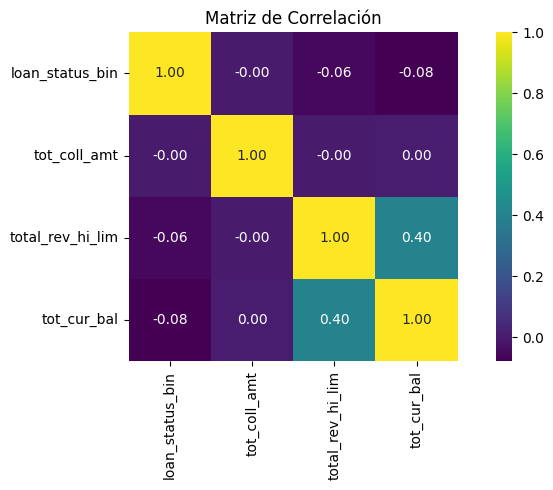

In [27]:
correlation_matrix = df1.corr(numeric_only=True)
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, cmap='viridis', annot=True, fmt=".2f", square=True)
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.show()

A partir de la matriz de correlación, se observa que no existe una asociación lineal significativa entre ninguna de las tres variables y el target. Sin embargo, se identifica una correlación moderada entre total_rev_hi_lim y tot_cur_bal, lo cual sugiere redundancia entre estas dos variables. Dentro de las tres, la que muestra mayor correlación (aunque débil) con el target es tot_cur_bal, y esta relación es inversa: a mayor saldo actual en las cuentas del solicitante, menor es la probabilidad de impago. Por esta razón, se decide conservar tot_cur_bal para evaluar posibles patrones no lineales más adelante, y descartar tot_coll_amt, por su correlación prácticamente nula, así como total_rev_hi_lim, por su alta relación con tot_cur_bal. Dado que tot_cur_bal será conservada, se procederá a imputar los valores faltantes en esta variable.

In [28]:
data_cleaned.drop(columns=['tot_coll_amt','total_rev_hi_lim'],inplace=True)

Antes de realizar la imputación vamos a corregir los faltantes en las otras variables donde el porcentaje es minimo, empezamos viendo la variable emp_length. 

In [29]:
data_cleaned['emp_length'].value_counts()

emp_length
10+ years    81250
2 years      25050
< 1 year     22461
3 years      21684
5 years      18993
1 year       18076
4 years      17140
6 years      15571
7 years      14849
8 years      12582
9 years      10153
Name: count, dtype: int64

Vamos a imputar los valores faltantes aleatoriamente entre las categorías existentes siguiendo la misma proporción que tienen en los datos observados. Para mantener así la distribución original de la variable y evitar sobre-representar la categoría más común (como al imputar con la moda).

In [30]:
np.random.seed(88)
emp_length_notnull = data_cleaned['emp_length'].dropna()
proportions = emp_length_notnull.value_counts(normalize=True)
n_missing = data_cleaned['emp_length'].isna().sum()
imputed_values = np.random.choice(proportions.index, size=n_missing, p=proportions.values)
data_cleaned.loc[data_cleaned['emp_length'].isna(), 'emp_length'] = imputed_values

El resto de variables que tienen menos del 0.1 % de datos faltantes se proceden a imputar con la mediana y con la moda, en variables numéricas y categóricas respectivamente. 

In [31]:
data_cleaned.columns[data_cleaned.isnull().any()].tolist()

['annual_inc',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_util',
 'total_acc',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_cur_bal']

In [32]:
data_cleaned[data_cleaned.columns[data_cleaned.isnull().any()].tolist()].info()

<class 'pandas.core.frame.DataFrame'>
Index: 268530 entries, 0 to 887371
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   annual_inc                  268526 non-null  float64
 1   delinq_2yrs                 268501 non-null  float64
 2   earliest_cr_line            268501 non-null  object 
 3   inq_last_6mths              268501 non-null  float64
 4   open_acc                    268501 non-null  float64
 5   pub_rec                     268501 non-null  float64
 6   revol_util                  268281 non-null  float64
 7   total_acc                   268501 non-null  float64
 8   collections_12_mths_ex_med  268385 non-null  float64
 9   acc_now_delinq              268501 non-null  float64
 10  tot_cur_bal                 201934 non-null  float64
dtypes: float64(10), object(1)
memory usage: 24.6+ MB


In [33]:
#Imputamos las variables numéricas continuas o discretas con muchos valores disitintos, con la mediana
cols_to_impute1 = ['annual_inc', 'open_acc', 'pub_rec', 'revol_util', 'total_acc']

for col in cols_to_impute1:
    median_value = data_cleaned[col].median()
    data_cleaned[col].fillna(median_value, inplace=True)

In [34]:
#Imputamos las variables categóricas o numéricos con valores discretos, con la moda
cols_to_impute2 = ['delinq_2yrs','earliest_cr_line','inq_last_6mths','collections_12_mths_ex_med', 'acc_now_delinq']

for col in cols_to_impute2:
    mode_value = data_cleaned[col].mode()[0]
    data_cleaned[col].fillna(mode_value, inplace=True)

In [35]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 268530 entries, 0 to 887371
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   268530 non-null  float64
 1   emp_length                  268530 non-null  object 
 2   home_ownership              268530 non-null  object 
 3   annual_inc                  268530 non-null  float64
 4   purpose                     268530 non-null  object 
 5   addr_state                  268530 non-null  object 
 6   dti                         268530 non-null  float64
 7   delinq_2yrs                 268530 non-null  float64
 8   earliest_cr_line            268530 non-null  object 
 9   inq_last_6mths              268530 non-null  float64
 10  open_acc                    268530 non-null  float64
 11  pub_rec                     268530 non-null  float64
 12  revol_bal                   268530 non-null  float64
 13  revol_util         

In [36]:
data_cleaned.columns

Index(['loan_amnt', 'emp_length', 'home_ownership', 'annual_inc', 'purpose',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'collections_12_mths_ex_med', 'application_type',
       'acc_now_delinq', 'tot_cur_bal', 'loan_status_bin'],
      dtype='object')

Usamos RandomForest Regressor para determinar inputar la variable 'tot_cur_bal', y para practicidad se van usar únicamente las variables numéricas. Este resultado es una mejor aproximación, que utilizar la media o la mediana, debido a la gran porcentaje de valores faltantes. 

In [37]:
numeric_df = data_cleaned[['loan_amnt', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'tot_cur_bal']].select_dtypes(include='number')
df_notnull = numeric_df[numeric_df['tot_cur_bal'].notnull()]
df_null = numeric_df[numeric_df['tot_cur_bal'].isnull()]

In [38]:
df_notnull['tot_cur_bal'].mean()

137111.3532936504

In [39]:
df_notnull['tot_cur_bal'].describe()

count    2.019340e+05
mean     1.371114e+05
std      1.514205e+05
min      0.000000e+00
25%      2.830400e+04
50%      7.912400e+04
75%      2.064080e+05
max      8.000078e+06
Name: tot_cur_bal, dtype: float64

In [40]:
df_notnull.shape, df_null.shape

((201934, 13), (66596, 13))

In [41]:
X_train = df_notnull.drop(columns='tot_cur_bal')
y_train = df_notnull['tot_cur_bal']

In [42]:
rf = RandomForestRegressor(random_state=42, n_estimators=30,n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=30, n_jobs=-1, random_state=42)

In [43]:
X_pred = df_null.drop(columns='tot_cur_bal')
predicted_values = rf.predict(X_pred)

In [44]:
data_cleaned.loc[data_cleaned['tot_cur_bal'].isnull(), 'tot_cur_bal'] = predicted_values

In [45]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 268530 entries, 0 to 887371
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   268530 non-null  float64
 1   emp_length                  268530 non-null  object 
 2   home_ownership              268530 non-null  object 
 3   annual_inc                  268530 non-null  float64
 4   purpose                     268530 non-null  object 
 5   addr_state                  268530 non-null  object 
 6   dti                         268530 non-null  float64
 7   delinq_2yrs                 268530 non-null  float64
 8   earliest_cr_line            268530 non-null  object 
 9   inq_last_6mths              268530 non-null  float64
 10  open_acc                    268530 non-null  float64
 11  pub_rec                     268530 non-null  float64
 12  revol_bal                   268530 non-null  float64
 13  revol_util         

Hasta se hace el preprocesamiento inicial del dataset, donde tenemos un total de 19 variables predictoras relacionadas con las caracteristicas iniciales de la persona para conocer su situación crediticia y la variable target loan_status_bin.

In [46]:
data_cleaned.to_csv('../data/processed/clean_data.csv', sep=',', index=False)

In [47]:
data_cleaned.head(1000).to_clipboard()

In [48]:
len(data_cleaned['collections_12_mths_ex_med'].unique()),data_cleaned['collections_12_mths_ex_med'].unique()

(7, array([0., 1., 2., 4., 3., 6., 5.]))